# This code takes input photoionization models and fits them to the observations of COS-Halos absorption systems

In [1]:
import numpy as np
import scipy.interpolate as interp
#import asciitable
from astropy.io import ascii
import xarray as xr
#import pickle as pk
import pandas as pd

print(xr.__version__,  pd.__version__)


2023.6.0 2.0.3


## Load in model

Define constants and metalicities used
Specifiy which ions to ignore (Low ions)

In [2]:
abundances = {'H':1, 'He':1/12, 'C':2.7e-4, 'N':6.7e-5, 'O':4.9e-4, 'Ne':8.5e-5, 'Mg':4.0e-5, 'Si':3.2e-5, 'S':1.3e-5 }
roman_dict = {'I':0, 'II': 1, 'III':2, 'IV':3, 'V':4, 'VI':5, 'VII':6}  #to map from indexes to array indexes;
            
    
#ignored ions 
dont_use_these_ions = ['O VI', 'H I', 'N I', 'Mg I', 'C I', 'O I', 'Si I', 'Fe I', 'Fe II', 'Fe III', 'N V']

 

RemoveBlends = 1  #removes lines that are specified as blends
min_sigma = 0.1 #minimum standard deviation allowed
max_logHI_column = 17.5  #maximum HI column density allowed
nsteps = 600 #converged at 600, but this slows calculation a lot
modelstring = 'lognormal' #'cool' #'lognormal'  #'mix' 'cool'   #'mixcool'
filestring = 'models_frac_eff_Z03'
numbofconstraints = 3  #has to be greater than or equal
epsilon_ionfrac = 1e-10


if modelstring == 'lognormal':
    modeldata  = xr.open_dataset(filestring + '_wss' ,group='gr1')
    model = modeldata.equilibrium #isothermal   equilibrium isobaric adiabatic
    
    modeldata_noss  = xr.open_dataset(filestring +'_noss',group='gr1')
    model_noss = modeldata_noss.equilibrium #isothermal   equilibrium isobaric adiabatic
else:
    modeldata  = xr.open_dataset(filestring+ '_wss',group='gr2') #mixcool
    modeldata_noss  = xr.open_dataset(filestring+ '_noss',group='gr2') #mixcool
    if modelstring == 'mix':
        model = modeldata.mix_lin_fix
        model_noss = modeldata_noss.mix_lin_fix
    elif modelstring == 'cool':
        model = modeldata.cooling_fix
        model_noss = modeldata_noss.cooling_fix
    #print(modeldata.param)
    else:
        print('no such model')



narray = modeldata.n0


# Calculate column for a given ion 

(this is only used in next two blocks and not be fitting code)

In [3]:
#takes in ion name and the total hydrogen column Nnorm
def getModelLogIonicColumn(ion_name, logNnorm, efrac_model):
    ion_name_split = ion_name.split()
    ion_name_nospace = ion_name_split[0].strip() + ion_name_split[1].strip()
    return logNnorm + np.log10(abundances[ion_name_split[0]]*(float(efrac_model.sel(ion=ion_name_nospace).values)+ epsilon_ionfrac))

##  examples of how to use model

In [4]:
#specific_model = model.isel(param=2).sel(n0=0.01,method='nearest')
specific_model = model.sel(param=0.8, method='nearest').sel(n0=0.01,method='nearest') 
     #for lognormal, param is the sigma.  For other models it is the fraction in the mixing/cooling gas

#for total hydrogen column of 10^20  print some columns produced by model
print("HI column= ", getModelLogIonicColumn('H I', 20, specific_model), \
      ", CIV column= ",getModelLogIonicColumn('C IV', 20, specific_model))

HI column=  18.746017890599905 , CIV column=  12.863714428608827


# Make plots of some models

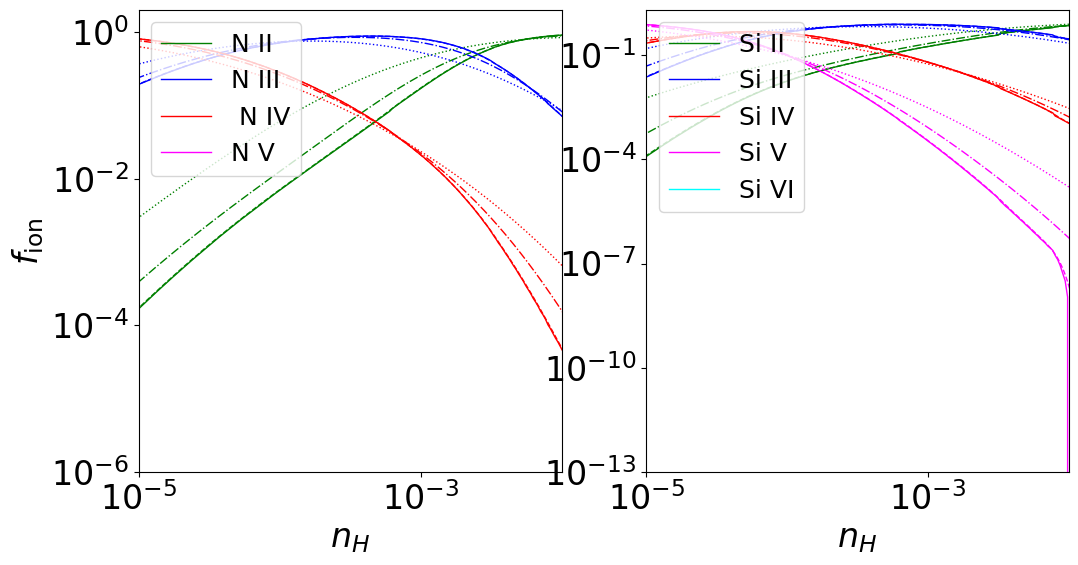

In [5]:
import matplotlib.pyplot as plt
lsarray= ['-', '--', '-.', ':']; colorarray = ['black', 'green', 'blue', 'red', 'magenta', 'cyan', 'brown']
plt.rcParams.update({'font.size': 24})
fig, (p1,p2)=plt.subplots(nrows=1, ncols=2,figsize=(12,6)) #,sharey='all')


##plot carbon
for ion_name in  ['N II', 'N III', ' N IV', 'N V']:
    ion_name_split = ion_name.split()
    ion_name_nospace = ion_name_split[0].strip() + ion_name_split[1].strip()
    ionization_val = roman_dict[ion_name_split[1]]
    

    i=0
    for p in modeldata.param.values:
        efrac_model = model.sel(param=p,method='nearest')
        if p == 0:
            legendstring = ion_name
        else:
            legendstring = ''
        p1.loglog(narray, efrac_model.sel(ion=ion_name_nospace).values,  linestyle=lsarray[i], color=colorarray[ionization_val%7],linewidth=1, label=legendstring)
        
        i+= 1
p1.legend(loc='upper left', fontsize=18)
p1.set_xlim([10**-5, .01])
p1.set_ylim([10**-6,2])

##plot silicon
for ion_name in  ['Si II', 'Si III', 'Si IV', 'Si V', 'Si VI']:
    ion_name_split = ion_name.split()
    ion_name_nospace = ion_name_split[0].strip() + ion_name_split[1].strip()
    ionization_val = roman_dict[ion_name_split[1]]
    
    
    i=0
    for model_sel in modeldata.param.values:
        efrac_model = model.sel(param=model_sel,method='nearest')
        if model_sel == 0:
            legendstring = ion_name
        else:
            legendstring = ''
        p2.loglog(narray, efrac_model.sel(ion=ion_name_nospace).values,  linestyle=lsarray[i], color=colorarray[ionization_val%7],linewidth=1, label=legendstring)

        i+= 1
    
p2.legend(loc='upper left', fontsize=18)
p2.set_xlim([10**-5, .01])
p2.set_ylim([10**-13,2])


p1.set_xlabel(r"$n_{H}$");p2.set_xlabel(r"$n_{H}$")
p1.set_ylabel(r"$f_{\rm ion}$")
fig.subplots_adjust(wspace=0.2)
p1.legend(loc='upper left', fontsize=18) # bbox_to_anchor=(1.12,.99),markerscale=1.5,framealpha=1,edgecolor='k')
#plt.savefig(f'./Savfig/Isochoric_coolingcolumns.png',bbox_extra_artists=(ionleg,), bbox_inches='tight')


# Read in  Cos-Halos data and output number of systems that meet criteria

In [6]:
metalprof=ascii.read('./Werk_metal_line_profile_fits.dat')
otherabs=ascii.read('./Werk_other_absorber_specs_YakovBlendIdenfication.dat')
HItablelarge = ascii.read('2017-Prochaska-apjaa6007t3_ascii.txt')
divions={}
#print(HItablelarge)

#file to restructure the input files for our purposes
def systemdict(ID,table):
    #ID is string name of system
    # table is asciitable.read 
    """
           ----    l_logNA    Limit flag on LogNA
          [cm-2]   logNA      Log of adopted ionic column density (4)
          [cm-2]   e_logNA    Uncertainty in logNA
    """

    constraint_count = 0
    limit_count = 0
    housing={}
    for i in range(len(table)):
        if RemoveBlends:
            flag = False if table[i]['Flg'] in [3,11] else True
        else:
            flag = True
        if table[i]['ID'] == ID and flag and isinstance(table[i]['logNA'], float)==True:
            if type(table[i]['e_logNA'])==np.ma.core.MaskedConstant:
                sigma=-1
                limit_count +=1
            else:
                sigma=table[i]['e_logNA']
                if table[i]['Ion'] not in dont_use_these_ions:
                    constraint_count += 1
            housing[table[i]['Ion']]=[table[i]['l_logNA'],table[i]['logNA'],sigma, ID]
            
             
    return [housing, constraint_count, limit_count]

HItable = [[HItablelarge[:][i][0].split()[0],  float(HItablelarge[:][i][2].split()[0]), HItablelarge[:][i][1], float(HItablelarge[:][i][2].split()[0])-HItablelarge[:][i][1]] for i in range(31)]
#HItable = [[HItablelarge[:][i][0].split()[0], HItablelarge[:][i][0].split()[5], HItablelarge[:][i][0].split()[4], HItablelarge[:][i][1], float(HItablelarge[:][i][2].split()[0])] for i in range(30)]
#print(HItable)
HItable  = (np.array(HItable)).reshape((31,4))
#print(HItable)

numberofsystems = 0 #counter
allwerksystems = []
constraint_array = []
ids_noduplicates = [i for n, i in enumerate(metalprof[:]['ID']) if i not in metalprof[:n]['ID']] 
logHI_column = 0
corrected = 0  #when this block is run, corrections then need to be applied (but not twice)

for i in range(len(ids_noduplicates)):
    #print(ids_noduplicates)
    housing, constraint_count, limit_count = systemdict(ids_noduplicates[i],otherabs)
    #print(ids_noduplicates[i], " # constraints = ", constraint_count)
    #galstring == HItable[:][jj][0].split()[0]
    logHI_column = 0 
    # only if in prochaska do we use
    print(ids_noduplicates[i])
    if ids_noduplicates[i] in HItable[:, 0]:
        index = np.where(ids_noduplicates[i] == HItable[:, 0])[0]
        logHI_column = float(HItable[index, 1][0])
        #print("Yes, contains", ids_noduplicates[i], logHI_column )
    #else:
    #print("No it doesn't contain", ids_noduplicates[i])
     # protab[:][jj][2].split()[0] 
    
    if constraint_count >= numbofconstraints and logHI_column < max_logHI_column:
        print(ids_noduplicates[i], " log NHI = ", logHI_column)
        allwerksystems.append(housing)
        numberofsystems +=1 
        constraint_array.append([constraint_count, limit_count])
    #if ids_noduplicates[i] == 'J1435+3604_68_12':
    #    print(housing, constraint_count)

print("number of systems with >= ", numbofconstraints, " constraints is ", numberofsystems)

J0226+0015_268_22
J0401-0540_67_24
J0803+4332_306_20
J0910+1014_34_46
J0910+1014_242_34
J0910+1014_242_34  log NHI =  16.63
J0914+2823_41_27
J0925+4004_196_22
J0928+6025_110_35
J0935+0204_15_28
J0943+0531_106_34
J0943+0531_216_61
J0943+0531_227_19
J0950+4831_177_27
J1009+0713_204_17
J1009+0713_170_9
J1016+4706_274_6
J1016+4706_274_6  log NHI =  17.1
J1016+4706_359_16
J1112+3539_236_14
J1133+0327_110_5
J1133+0327_164_21
J1220+3853_225_38
J1233+4758_94_38
J1233+4758_94_38  log NHI =  16.8
J1233-0031_168_7
J1241+5721_199_6
J1241+5721_208_27
J1241+5721_208_27  log NHI =  15.29
J1245+3356_236_36
J1322+4645_349_11
J1322+4645_349_11  log NHI =  17.1
J1330+2813_289_28
J1330+2813_289_28  log NHI =  17.12
J1342-0053_157_10
J1342-0053_77_10
J1419+4207_132_30
J1435+3604_126_21
J1435+3604_68_12
J1437+5045_317_38
J1445+3428_232_33
J1514+3619_287_14
J1550+4001_197_23
J1550+4001_197_23  log NHI =  16.5
J1550+4001_97_33
J1555+3628_88_11
J1555+3628_88_11  log NHI =  17.46
J1617+0638_253_39
J1619+3342_11

# Make corrections to the systems based on our analysis of what systems look like

In [7]:
#only makes the correction once by setting the "correction" flag.  
##########################################################################
#If you change this code, rerun previous block to read in data first
##########################################################################
if corrected == 0:
    ss_flag = {}
    for Nsyst in allwerksystems:
        print(Nsyst['H I'][-1] )
        ss_flag[Nsyst['H I'][-1]] = False
        if  Nsyst['H I'][-1] == 'J0910+1014_242_34':
            print(Nsyst['H I'][-1], " CIII before = ", Nsyst['C III'][1]),
            Nsyst['C III'][1] =  13.89 #np.log10(10**Nsyst['C III'][1]- 10**13.49 - 10**13.34)
            #Nsyst['C III'][0] =  ''; Nsyst['C III'][2] = 0.9
            
            print(Nsyst['H I'][-1], "CIII after = ", Nsyst['C III'][1])
            print(Nsyst['C II'][0])
        #if  Nsyst['H I'][-1] == 'J1016+4706_274_6':
            #print(Nsyst['H I'][-1], "waiting for resolution of adding issue before I subtract"),
            #Nsyst['Si II'][1] =  np.log10(10**Nsyst['Si II'][1]- 10**12.63)
            #Nsyst['Si III'][1] =  np.log10(10**Nsyst['Si III'][1]- 10**12.74)
            #print(Nsyst['H I'][-1], " Si II after = ", Nsyst['Si II'][1], " Si III after = ", Nsyst['Si III'][1])
        #if  Nsyst['H I'][-1] = 'J1233+4758_94_38':   
        #if Nsyst['H I'][-1] == 'J1241+5721_208_27':
        #    ss_flag[Nsyst['H I'][-1]] = False
        if  Nsyst['H I'][-1] == 'J1322+4645_349_11':
            print(Nsyst['H I'][-1], " Si II before = ", Nsyst['Si II'][1], " Si III before = ", Nsyst['Si III'][1]),
            Nsyst['Si II'][1] =  13.37; #Nsyst['Si II'][2] = 0.15 #np.log10(10**Nsyst['Si II'][1]- 10**12.63)
            Nsyst['Si III'][1] = 13.73 #  np.log10(10**Nsyst['Si III'][1]- 10**12.74)
            Nsyst['Si III'][0] =  ''; Nsyst['Si III'][2] = 0.2
            
            print(Nsyst['H I'][-1], " Si II after = ", Nsyst['Si II'][1], " Si III after = ", Nsyst['Si III'][1])
            #ss_flag[Nsyst['H I'][-1]] = True
        if  Nsyst['H I'][-1] == 'J1550+4001_197_23':
            print(Nsyst['H I'][-1], " Mg II before = ", Nsyst['Mg II'][1], " C II before = ", Nsyst['C II'][1], " C III before = ", Nsyst['C III'][1]),
            Nsyst['Mg II'][1] =  12.63 
            Nsyst['C II'][1] =  13.98 #np.log10(10**Nsyst['C II'][1]- 10**13.51)
            #Nsyst['C III'][1] =  14.91 #np.log10(10**Nsyst['C III'][1]- 10**12.88)
            #Nsyst['C III'][0] =  ''; Nsyst['C III'][2]=0.9
            
            print(Nsyst['H I'][-1], " Mg II after = ", Nsyst['Mg II'][1], " C II after = ", Nsyst['C II'][1], "C III after = ", Nsyst['C III'][1])
        #if  Nsyst['H I'][-1] == 'J1555+3628_88_11':
        #    ss_flag[Nsyst['H I'][-1]] = True
        #if Nsyst['H I'][-1] == 'J2345-0059_356_12':
        #    ss_flag[Nsyst['H I'][-1]] = False

    corrected = 1
    #N_observed_dict_[ion][1]
print(ss_flag)

J0910+1014_242_34
J0910+1014_242_34  CIII before =  13.84
J0910+1014_242_34 CIII after =  13.89
--
J1016+4706_274_6
J1233+4758_94_38
J1241+5721_208_27
J1322+4645_349_11
J1322+4645_349_11  Si II before =  13.41  Si III before =  13.65
J1322+4645_349_11  Si II after =  13.37  Si III after =  13.73
J1330+2813_289_28
J1550+4001_197_23
J1550+4001_197_23  Mg II before =  12.71  C II before =  14.05  C III before =  14.1
J1550+4001_197_23  Mg II after =  12.63  C II after =  13.98 C III after =  14.1
J1555+3628_88_11
J2345-0059_356_12
{'J0910+1014_242_34': False, 'J1016+4706_274_6': False, 'J1233+4758_94_38': False, 'J1241+5721_208_27': False, 'J1322+4645_349_11': False, 'J1330+2813_289_28': False, 'J1550+4001_197_23': False, 'J1555+3628_88_11': False, 'J2345-0059_356_12': False}


# Routines for fitting the COS-Halos data and returning best fit and chi^2 values

In [8]:
#given a model for logNmodel, compares against data to calculate chi^2
def chi2_contr(ion_name, logNmodel,logNobs,sigma,l_logNA, large_value=1e5):
    #print(ion_name, ": ", logNobs,sigma,l_logNA)

    if l_logNA == '>': #observations  are upper limit
        sigvec = np.copy(logNmodel)
        epsilon = np.copy(logNmodel)
        sigvec[logNmodel > logNobs]= large_value # model fits observations, so small contribution to chi^2
        sigvec[logNmodel < logNobs]=(min_sigma)
        epsilon[logNmodel < logNobs] = -2*min_sigma #assumes quoted limit is 2 sigma
        

    elif l_logNA == '<': #observations  are lower limit
        sigvec = np.copy(logNmodel)
        epsilon = np.copy(logNmodel)
        sigvec[logNmodel < logNobs]= large_value # model fits observations, so small contribution to chi^2
        sigvec[logNmodel > logNobs]=(min_sigma)
        epsilon[logNmodel > logNobs] = 2*min_sigma  #assumes  quoted limit is 2 sigma

    else:  #observations  are constrained
        sigvec= np.max([min_sigma, sigma]) #sets error bar to be maximum
        epsilon = 0 #*sigvec 

    chi2_contr_eqn=((logNmodel + epsilon)-logNobs)**2 /( sigvec**2 )  
         #for the bounds, epsilon gives 2 sigma error when logNmodel=logNobs

    if np.isinf( chi2_contr_eqn[0]):
        print("chisq = ", chi2_contr_eqn, ion_name, logNmodel,logNobs,sigma,l_logNA)
    return chi2_contr_eqn


#takes observed columns and returns contribution to chi^2
def chi_squared_vector(N_observed_dict_, efrac_model, nHrange, logNnorm): 
    ### chi2_contr is to calculate individual chi2 of an ion 
    
    nHlen  =  sum(nHrange.values)

    
    #model_ions=list(efffrac_dict_.keys())        #create list of ions in model
    observed_ions=list(N_observed_dict_.keys())  #create list of ions in observations
    
    #print("observed_ions = ", observed_ions)
    
    comp_ions=[]
    for ion in observed_ions:
        #if ion in model_ions:
        comp_ions.append(ion)  #this ensures we are only looking at the ions that are present in our and Werk's model

    
    
    chisq_vec = np.zeros(nHlen)
    Nions_fit = 0;  Nions_notlimits = 0
    ion_name_list = []
    
    #loops through ions
    for ion in comp_ions:
        #print("ion =", ion)
        if ion in dont_use_these_ions:  #skip
            continue
        
        #convert to name that has not spaces for dictionary
        ion_name_split = ion.split()
        ion_name_nospace = ion_name_split[0].strip() + ion_name_split[1].strip()  
        #this is the calculation of the columns (doesn't use function below)
        logNHmodelarray =  logNnorm + np.log10(abundances[ion_name_split[0]]) \
            + np.log10(efrac_model.sel(ion=ion_name_nospace).values[nHrange]+epsilon_ionfrac)        
        
            
        #these are the observed columns, error, and error flag    
        logNobs=N_observed_dict_[ion][1]
        sigma=N_observed_dict_[ion][2]
        l_logNA=N_observed_dict_[ion][0]
        

        chisq_vec += chi2_contr(ion_name_nospace, logNHmodelarray,logNobs,sigma,l_logNA)
        
        #print("chisq_vec_min = ",  np.min(chisq_vec))
        
        Nions_fit +=1
        if l_logNA != '<' and l_logNA != '>':
            Nions_notlimits += 1 
            
        #break
        ion_name_list.append(ion)
        
    return [chisq_vec, Nions_fit, Nions_notlimits, ion_name_list]

#scans over total columns in search of best fit (density is vectorized)
def findSmallestChisq(Nsyst, efrac_model, nHrange, p):
    min_chisq = 1e10 #start with a high value
    
    #loop over total column values (metalicity is in the total column parameter)
    #THIS IS SUPER STUPID, SHOULD BE ABLE TO RETURN BEST FIT AMPLITUDE
    #could really do this by evaluating at two points if my chi^2 was not discontinous at upper/lower limits
    for logNtot in np.linspace(16, 22, nsteps):
        [chisq_vec, Nions_fit, Nions_notlimits, ion_name_list] =chi_squared_vector(Nsyst, efrac_model, nHrange, logNtot)
        newestmin = np.min(chisq_vec)

        if newestmin < min_chisq: #save best fit
            min_chisq = newestmin
            logNbest = logNtot
            ibest = np.argmin(chisq_vec)
            #print("lengths = ", len(chisq_vec), len(nHrange), nHrange)
            nHbest = (narray[nHrange == True])[ibest]['n0'].item()

    return [min_chisq, logNbest, ibest, nHbest, ion_name_list, p]


#finds the best fit logN at each density (for trouble shooting) -- I started to put this in on 1/19/24
def findSmallestChisqEachDensity(Nsyst, efrac_model, nHrange):
    min_chisq = 1e10
    
    logNtotbestvec = np.zeros(np.count_nonzero(nHrange))
    minchisqvec = np.zeros(np.count_nonzero(nHrange))+min_chisq
    #print("size of array is ", np.shape(nHrange == True), np.shape(nHrange), np.shape(logNtotbestvec))
    #loop over total column values to find best fit at each density
    for logNtot in np.linspace(16, 22, nsteps):
        [chisq_vec, Nions_fit, Nions_notlimits, ion_name_list] =chi_squared_vector(Nsyst, efrac_model, nHrange, logNtot)
     
        logNtotbestvec[chisq_vec < minchisqvec] = logNtot
        minchisqvec[chisq_vec < minchisqvec] = chisq_vec[chisq_vec < minchisqvec]
     

        #print(logNtotbestvec)

    return [logNtotbestvec, minchisqvec]


#Calculates the errors (currently on dN only)
dchisq = 2.3 #difference in chi^2 for 2D data that has 68.3% interior (assuming a Gaussian)
def findParameterErrors(Nsyst, efrac_model, nHrange, X):
    #loop over total column values
    [min_chisq, logNbest, ibest, nHbest, ion_name_list, pdummy] = X
    
    dlogN = -1
    for logNtot in np.linspace(logNbest, logNbest+0.4, 200):  #this is tuned since error is never greater than 0.2ish
        [chisq_vec, Nions_fit, Nions_notlimits, ion_name_list] =chi_squared_vector(Nsyst, efrac_model, nHrange, logNtot)
        if np.min(chisq_vec) < min_chisq + dchisq:
            #print("dN = ", logNtot, logNbest, np.min(chisq_vec),  min_chisq)
            dlogN = logNtot - logNbest #error on column
        else: #I added this to speed up
            break
      
    #now the same but for density
    dlogn = -1; #error on density (currently does not find)
    

    [logNtotbestvec, chisq_vec] = findSmallestChisqEachDensity(Nsyst,efrac_model, nHrange)
    #print(chisq_vec,  np.min(chisq_vec))
    min_chisqnew = np.min(chisq_vec)
    imin_chisq = np.argmin(chisq_vec)
    ilognH = np.argmin(np.abs(chisq_vec - (min_chisq + dchisq)))
    nHarr = narray[nHrange]
    
    #print(dchisq, "chi^2 = ", chisq_vec)
    dlogn = np.abs(np.log10(nHarr[ilognH].values) - np.log10(nHarr[ibest].values)) #error on column
 
    #print("values ", imin_chisq, min_chisq, ilognH,  chisq_vec[ilognH], nHarr[ilognH].values, np.log10(nHarr[imin_chisq].values), dlogn)

    #now calculate metalicity
    Z=0; dlogZ=0
    
    #print("should be equal ", ibest, imin_chisq, " lengths, ", min_chisqnew, min_chisq, nHarr[ibest].values, nHarr[imin_chisq].values)
     
    # only if in prochaska do we use
    if Nsyst['H I'][-1] in HItable[:, 0]:
        index = np.where( Nsyst['H I'][-1]== HItable[:, 0])[0]
        logHI_column = float(HItable[index, 2][0])
        dlogNHI = float(HItable[index, 3][0])
        efrac_vec = np.array(efrac_model.sel(ion='HI').values)[nrange]
        #print("nHI ", logNbest, logHI_column, efrac_vec[ibest])
        Z = 10**logNbest/(10**logHI_column/(efrac_vec[ibest]+epsilon_ionfrac))
        dfdn = (efrac_vec[ibest+1]-efrac_vec[ibest])/(nHarr.values[ibest+1] - nHarr.values[ibest])*nHarr.values[ibest]/efrac_vec[ibest]
        dlogZ = np.sqrt(dlogN**2 +dlogNHI**2 + (dfdn*dlogn)**2)
        
    return [dlogN, dlogn, Z, dlogZ]


#major fitting code
def fitSystems(nrange, allwerksystems, model,  modeldata, calc_errors=0):

    logNbest = None
    all_systems = []
    for Nsyst in allwerksystems:
        systemvaluesparameters = []
        bestfitvalues = []
        for p in modeldata.param.values:    

            efrac_model  = model.sel(param=p, method ='nearest')  #.sel(n0=0.01,method='nearest')
            nHvec =modeldata.n0[nrange].values
            nHlength  =  sum(nrange.values)


            #min_chisq, logNbest, ibest, nHbest, ion_name_list = findSmallestChisq(Nsyst, efrac_model, nrange)    
            bestfitparams = findSmallestChisq(Nsyst, efrac_model, nrange, p)    
            min_chisq, logNbest, ibest, nHbest, ion_name_list, pdummy = bestfitparams

            print(p, "minchisq =", min_chisq, nHbest, logNbest, pdummy)

            if calc_errors:
                [dlogN, dlogn, Z, dlogZ] = findParameterErrors(Nsyst, efrac_model, nrange, bestfitparams)
                print("errors =", dlogN, dlogn, Z, dlogZ)


            ion_names = []
            logNmodel_values = []
            logNobs_values = []
            sigma_values = []
            limit_values = []

            for ion in ion_name_list:
                # Convert to name that has no spaces for dictionary
                ion_name_split = ion.split()
                ion_name_nospace = ion_name_split[0].strip() + ion_name_split[1].strip()

                # Get observed ion info
                logNobs = Nsyst[ion][1]
                if Nsyst[ion][2] > 0:
                    sigma = max(min_sigma, Nsyst[ion][2])
                else:
                    sigma =  Nsyst[ion][2]
                l_logNA = Nsyst[ion][0]

                efrac_vec = np.array(efrac_model.sel(ion=ion_name_nospace).values)[nrange]
                logNmodel = logNbest + np.log10(abundances[ion_name_split[0]]) + np.log10(efrac_vec[ibest]+epsilon_ionfrac)

                # Append values to the arrays
                ion_names.append(ion)
                logNmodel_values.append(logNmodel)
                logNobs_values.append(logNobs)
                sigma_values.append(sigma)
                limit_values.append(l_logNA)

                print(ion, "model vs observed = ", logNmodel, logNobs, sigma, l_logNA)

            systemvaluesparameters.append([ion_names, logNmodel_values, logNobs_values, sigma_values, limit_values])
            bestfitvalues.append(bestfitparams)
            
            #print("best fit params = ", bestfitparams)

        all_systems.append([bestfitvalues, systemvaluesparameters])
        
    return all_systems

    

# This generates the fits (takes some time)

In [ ]:
nrange = np.logical_and(narray> 1e-5, narray< 1e-1)

#self sheilding fits
all_systems = fitSystems(nrange, allwerksystems, model, modeldata, calc_errors=0)

#fits that aren't self shielding
all_systems_noss = fitSystems(nrange,  allwerksystems, model_noss, modeldata_noss, calc_errors=0)    

0.0 minchisq = 15.774908026099602 0.0031622776601683794 18.173622704507512 0.0
C II model vs observed =  14.170899222683776 14.08 0.13 --
C III model vs observed =  14.403599118958194 13.89 -1 >
N II model vs observed =  13.770797604054072 14.17 0.12 --
Mg II model vs observed =  13.213578599149047 13.01 0.1 --
Si II model vs observed =  13.25553642625159 13.22 0.13 --
Si IV model vs observed =  11.768353856560344 12.98 -1 <
S II model vs observed =  12.79109746458808 14.82 -1 <
0.1 minchisq = 16.048291758060277 0.003037079360069222 18.18363939899833 0.1
C II model vs observed =  14.173263100244315 14.08 0.13 --
C III model vs observed =  14.417781982130043 13.89 -1 >
N II model vs observed =  13.77009845840676 14.17 0.12 --
Mg II model vs observed =  13.217100403399089 13.01 0.1 --
Si II model vs observed =  13.26845308194807 13.22 0.13 --
Si IV model vs observed =  11.803083268886851 12.98 -1 <
S II model vs observed =  12.793407800956409 14.82 -1 <
0.6 minchisq = 17.71737518307462 0

0.0 minchisq = 7.3629926791472515 0.000941204967268067 18.59432387312187 0.0
C II model vs observed =  14.193513919646996 14.34 0.1 --
C III model vs observed =  14.9478043386443 14.34 -1 >
N II model vs observed =  13.614343776886415 14.04 -1 <
N III model vs observed =  14.334153746016582 14.37 0.1 --
Mg II model vs observed =  13.21234966715016 13.03 0.1 --
Si II model vs observed =  13.327652378526285 13.37 0.1 --
Si III model vs observed =  13.981730636069651 13.73 0.2 
Si IV model vs observed =  12.930968701643682 13.41 -1 <
S II model vs observed =  12.781568855722151 14.59 -1 <
0.1 minchisq = 7.370913467859196 0.000941204967268067 18.58430717863105 0.1
C II model vs observed =  14.186610439527982 14.34 0.1 --
C III model vs observed =  14.937174607267442 14.34 -1 >
N II model vs observed =  13.610721979524973 14.04 -1 <
N III model vs observed =  14.32293176394761 14.37 0.1 --
Mg II model vs observed =  13.205819052363584 13.03 0.1 --
Si II model vs observed =  13.3199752284058

0.6 minchisq = 35.95605572473692 0.0005134832907437555 18.994991652754592 0.6
C II model vs observed =  14.476781520947656 14.49 0.1 --
C III model vs observed =  15.354430582972613 14.3 -1 >
N II model vs observed =  13.888054232836424 14.3 0.1 --
N III model vs observed =  14.739600638887907 14.55 0.1 --
Mg II model vs observed =  13.497755892566218 13.26 0.1 --
Si II model vs observed =  13.611921115204005 13.41 0.1 --
Si III model vs observed =  14.370450703630837 13.53 -1 >
Si IV model vs observed =  13.594919523292106 13.88 0.12 --
S II model vs observed =  13.05931165876024 14.66 -1 <
1.2 minchisq = 24.816046943770946 0.00022890175519210516 18.9449081803005 1.2
C II model vs observed =  14.455303709197183 14.49 0.1 --
C III model vs observed =  15.276507503507066 14.3 -1 >
N II model vs observed =  13.932554806310185 14.3 0.1 --
N III model vs observed =  14.643694695044019 14.55 0.1 --
Mg II model vs observed =  13.492189444845962 13.26 0.1 --
Si II model vs observed =  13.5792

# Makes the plots

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import re


color_array = ['black', 'red',  'green', 'blue']

# Function to extract the Roman numeral from ion names
def extract_roman_numeral(ion_name):
    match = re.search(r'\b[IVXLCDM]+\b', ion_name)
    if match:
        return match.group()
    return ""

fig, ax = plt.subplots(nrows=len(all_systems)//3, ncols=3, figsize=(18, 10))

for isys in range(len(all_systems)):
    ix = isys//3
    iy = isys%3
    
    if ss_flag[allwerksystems[isys]['H I'][-1]] == False:
        all_systems_plot = all_systems_noss
        all_systems_other = all_systems
        default_linestyle = '-'
        other_linestyle = '--'
    else:
        all_systems_plot = all_systems
        all_systems_other = all_systems_noss
        default_linestyle = '--'
        other_linestyle = '-'
        
    # Sort data by Roman numeral
    [ion_names, logNmodel_values, logNobs_values, sigma_values, limit_values] = all_systems_plot[isys][1][0]
    
    ip =0
    chisq_arr = []
    
    for p in modeldata.param.values[[0, -2, -1]]: 
        if ip!=0:
            [ion_names, logNmodel_values, logNobs_values, sigma_values, limit_values] = all_systems_plot[isys][1][ip]
            #sorted_data = sorted(zip(ion_names, logNmodel_values, logNobs_values, sigma_values, limit_values), key=lambda x: extract_roman_numeral(x[0]))

        ax[ix, iy].plot(np.arange(len(ion_names)), logNmodel_values, linestyle=default_linestyle,\
                color=color_array[ip], label=rf'$\sigma={p}$')
        
        if ip == 0:
            [ion_names, logNmodel_values, logNobs_values, sigma_values, limit_values] = all_systems_other[isys][1][ip]

            ax[ix, iy].plot(np.arange(len(ion_names)), logNmodel_values, linestyle=other_linestyle,\
                color=color_array[ip], label=rf'$\sigma={p}$')
            chisq_other = all_systems_other[isys][0][ip][0]

            
        chisq_arr.append(all_systems_plot[isys][0][ip][0])
        #print(ip, "chisq = ", all_systems_plot[isys][0][ip][0], p)
        
        
        
        ip += 1
        
        

    for i, ion in enumerate(ion_names):
        x = i
        y = logNobs_values[i]
        sigma = sigma_values[i]
        if sigma < 0:
            if limit_values[i] == '>':
                ax[ix, iy].errorbar(x, y, yerr=min_sigma, marker='o', markersize=0, color='blue', capsize=5, lolims=True)
            if limit_values[i] == '<':
                ax[ix, iy].errorbar(x, y, yerr=min_sigma, marker='o', markersize=0, color='blue', capsize=5, uplims=True)
        else:
            ax[ix, iy].errorbar(x, y, yerr=sigma, marker='o', markersize=8, color='blue', capsize=5, label=f'{ion} Observed')

        

    print("chisq = ", chisq_arr)
    
    # Set x-axis labels and tick positions
    ax[ix, iy].set_ylim(11.5, 15.5)
    ax[ix, iy].set_xticks(np.arange(len(ion_names)))
    ax[ix, iy].set_xticklabels(ion_names, rotation=45, ha='right')
    ax[ix, iy].tick_params(axis='both', labelsize=14)  
    
    system_name = allwerksystems[isys]['H I'][-1] #.replace('_', '\_')
    ax[ix,iy].set_title(system_name, fontsize=15)
    
    min_index = np.argmin(chisq_arr); max_index = np.argmax(chisq_arr)

    
    ax[ix, iy].text(len(ion_names)-1, 11.5, rf'$\chi^2= ${min(chisq_arr):.1f}-{max(chisq_arr):.1f}, {chisq_other:.1f}', \
                    ha='right', va='bottom', fontsize=15, color=color_array[min_index])


    #ax.legend()
ax[1, 0].set_ylabel('Column Density [cm$^{-2}$]')
# Show the plot
plt.tight_layout()
#plt.show()

plt.savefig(f'systemfits_onlyobservedions_{modelstring}.pdf')

# Let's now create a plot that shows the same ions for every system

In [ ]:

ion_names_use = ['C II', 'C III', 'C IV' 'N II', 'N III', 'N V', 'Mg II', 'Si II', 'Si III', 'Si IV', 'S II', 'S III']
color_array = ['black', 'magenta', 'green', 'cyan']
width_array=[3, 2, 1, 1]

fig, ax = plt.subplots(nrows=len(all_systems)//3, ncols=3, figsize=(18, 16))

for isys in range(len(all_systems)):
    ix = isys//3
    iy = isys%3
    
    if ss_flag[allwerksystems[isys]['H I'][-1]] == False:
        all_systems_plot = all_systems_noss
        all_systems_other = all_systems
        default_linestyle = '-'
        other_linestyle = '--'
        efrac_model = model_noss
        efrac_other = model
    else:
        all_systems_plot = all_systems
        all_systems_other = all_systems_noss
        default_linestyle = '--'
        other_linestyle = '-'
        efrac_model = model
        efrac_other = model_noss
        
    # Sort data by Roman numeral
    [ion_names, logNmodel_values, logNobs_values, sigma_values, limit_values] = all_systems_plot[isys][1][0]
    
    ip =0
    chisq_arr = []
    

    
    for p in modeldata.param.values[[0, -2, -1]]: 
        if ip!=0:
            [ion_names, logNmodel_values, logNobs_values, sigma_values, limit_values] = all_systems_plot[isys][1][ip]
            #sorted_data = sorted(zip(ion_names, logNmodel_values, logNobs_values, sigma_values, limit_values), key=lambda x: extract_roman_numeral(x[0]))

        logNnorm = all_systems_plot[isys][0][ip][1]
        nH = all_systems_plot[isys][0][ip][3]
        modelfrac =  efrac_model.sel(param=p, method='nearest').sel(n0=nH,method='nearest') 
        #print(efrac_model.sel(param=p, method='nearest').sel(n0=nH,method='nearest').sel(ion='HI').values)
        logN = [getModelLogIonicColumn(ion_name, logNnorm, modelfrac) for ion_name in ion_names_use]
        
        ax[ix, iy].plot(np.arange(len(ion_names_use)), logN, linewidth=width_array[ip],linestyle=default_linestyle,\
                color=color_array[ip], label=rf'$\sigma={p}$')
        
        if ip == 0:
            [ion_names, logNmodel_values, logNobs_values, sigma_values, limit_values] = all_systems_other[isys][1][ip]
        
            logNnorm = all_systems_other[isys][0][ip][1]
            nH = all_systems_other[isys][0][ip][3]
            modelfrac =  efrac_other.sel(param=p, method='nearest').sel(n0=nH,method='nearest') 
            logN = [getModelLogIonicColumn(ion_name, logNnorm, modelfrac) for ion_name in ion_names_use]        
        
            ax[ix, iy].plot(np.arange(len(ion_names_use)), logN, linewidth=3, linestyle=other_linestyle,\
                color=color_array[ip], label=rf'$\sigma={p}$')
            chisq_other = all_systems_other[isys][0][ip][0]

            
        chisq_arr.append(all_systems_plot[isys][0][ip][0])
        
        
        ip += 1
        
        

    for i, ion in enumerate(ion_names):
        x = ion_names_use.index(ion)
        y = logNobs_values[i]
        sigma = sigma_values[i]
        if sigma < 0:
            if limit_values[i] == '>':
                ax[ix, iy].errorbar(x, y, yerr=min_sigma, marker='o', markersize=0, color='blue', capsize=5, lolims=True)
            if limit_values[i] == '<':
                ax[ix, iy].errorbar(x, y, yerr=min_sigma, marker='o', markersize=0, color='blue', capsize=5, uplims=True)
        else:
            ax[ix, iy].errorbar(x, y, yerr=sigma, marker='o', markersize=8, color='blue', capsize=5, label=f'{ion} Observed')

        

    print("chisq = ", chisq_arr)
    
    # Set x-axis labels and tick positions
    ax[ix, iy].set_ylim(11.5, 15.5)
    ax[ix, iy].set_xticks(np.arange(len(ion_names_use)))
    ax[ix, iy].set_xticklabels(ion_names_use, rotation=45, ha='right')
    ax[ix, iy].tick_params(axis='both', labelsize=18)  
    ax[ix, iy].grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
    
    system_name = allwerksystems[isys]['H I'][-1] #.replace('_', '\_')
    ax[ix,iy].set_title(system_name, fontsize=18)
    
    min_index = np.argmin(chisq_arr); max_index = np.argmax(chisq_arr)

    
    #ax[ix, iy].text(len(ion_names_use)-1, 11.5, rf'$\chi^2= ${min(chisq_arr):.1f}-{max(chisq_arr):.1f}, {chisq_other:.1f}', \
    #                ha='right', va='bottom', fontsize=18, color=color_array[min_index])
    ax[ix, iy].text(len(ion_names_use)-1, 15, rf'$\chi^2= ${chisq_arr[0]:.1f}, {chisq_arr[1]:.1f}, {chisq_arr[2]:.1f}; {chisq_other:.1f}', \
                    ha='right', va='top', fontsize=18, color='black')
    
    if ix != 0:
        ax[ix, iy].set_yticklabels([])
    #ax.legend()
ax[1, 0].set_ylabel('Column Density [cm$^{-2}$]')
# Show the plot
#plt.tight_layout()
plt.subplots_adjust(left=0.1, right=0.1, top=0.9, bottom=0.1, wspace=0)

#plt.show()

plt.savefig(f'systemfits_{modelstring}.pdf')


# Generates table with fitted values

In [ ]:
latex_output = 0 #output in latex
print_shielding = True

def SciNotation(num):
    #print("n0 = ", num)
    x='%.1e'  %num  #<-- Instead of 2, input sig here
    x= x.split('e')
    if (x[1])[0] == "-":
        return "$" +x[0]+r" \times 10^{-"+ x[1][-1] +"}$"
    else:
        return "$" + x[0]+r" \times x 10^{"+ (x[1])[-1] +"}$"

#Nsyst=allwerksystems[0] #Werkdict['_27']['_dict']

if latex_output == 0:
    print(f"#system constraints limits  best_fit_n(X={model.param.values}) best_fit_lgNZ(X={model.param.values}) \
    chi^2(X={model.param.values})   error_logn(X={model.param.values}) error_logN(X={model.param.values}) \
    Z(X={model.param.values}) error_logZ(X={model.param.values}) sometimes:bestfit_params_shielded(nH N Z + errors)")


#for p in lognormal.param:
p=0
i=0
for index, Nsyst in enumerate(allwerksystems):
    bestfit_params={}
    dlogN = {}; dlogn ={}; Z={}; dlogZ={}


    for p in model.param.values: 
        #print("p =", p)
        if ss_flag[Nsyst['H I'][-1]] == False:
            efrac_model  = model_noss.sel(param=p,method='nearest')
        else:
            efrac_model  = model.sel(param=p,method='nearest')
        bestfit_params[p] = findSmallestChisq(Nsyst, efrac_model, nrange, p)    # [min_chisq, logNbest, ibest, nHbest]
        #print(bestfit_params[p])
        if latex_output == 0:
            [dlogN[p], dlogn[p], Z[p], dlogZ[p]] = findParameterErrors(Nsyst, efrac_model, nrange, bestfit_params[p])
            #print('dN = ', dN)


    #print(Nsyst['H I'][-1], "nH = ", bestfit_params[0][3], bestfit_params[0.8][3],  " chisq = ", [bestfit_params[p][0] for p in lognormal.param.values], constraint_array[i])
    chisq = ["%.1f"%bestfit_params[p][0] for p in model.param.values]

    if print_shielding: #need to put this back in
        bestfit_params_shielded = findSmallestChisq(Nsyst, model.sel(param=0,method='nearest'), nrange, 0)
        [dlogNss, dlognss, Zss, dlogZss] = findParameterErrors(Nsyst, model.sel(param=0,method='nearest'), \
                                                               nrange, bestfit_params_shielded)

    if latex_output:
        print( Nsyst['H I'][-1].replace('_', '\_') , ' &', constraint_array[i][0], '&', constraint_array[i][1], '&', \
              SciNotation(bestfit_params[0][3]),'&', SciNotation(bestfit_params[ model.param.values[-2]][3]), \
              '&', SciNotation(bestfit_params[ model.param.values[-1]][3]['n0'].item()), \
              '&', float(chisq[0]),'&', float(chisq[1]),'&', float(chisq[2]),'&', float(chisq[3])),\
              r'\\'  #, '& comments here \u005c\u005c')
    else:
        print( Nsyst['H I'][-1], constraint_array[i][0], constraint_array[i][1],\
              [bestfit_params[p][3] for p in model.param.values], \
              [bestfit_params[p][1]for p in model.param.values],\
              [float(chisq[i]) for i in range(len(model.param.values))],\
              [dlogn[p] for p in model.param.values], [dlogN[p] for p in model.param.values], \
              [Z[p] for p in model.param.values], [dlogZ[p] for p in model.param.values], end='')
        if print_shielding:
            print((bestfit_params_shielded[3], bestfit_params_shielded[1], Zss, dlognss, dlogNss, dlogZss))
        print('')

        i+=1
    #print(Nsyst['H I'][-1],  " chisq = ", [bestfit_params[p][-1] for p in lognormal.param.values])

# Some notes on systems

J1241+5721_208_27: Looking at some of these J1241+5721_208_27 has high chi^2 because in part large SiIV column that all models cannot fit and so it's hard to fit this and the other lines of Si.  We fit a lower density than Jess (who finds 10^-3 and us 2x10^-4) because I think we include NV in the fit and she doesn't, and so combination of SiIV and NV.

J1016+4706_359_16: model predicts too high CII and too low Mg II.  Have not reconciled this one with Jess solution, which seems to more naturally go through these.  Might remake her plot

J1330+2813_289_28 fails very badly on CIII (by an order of magnitude).  

The property shared by two of the three high chi^2 is that the density is low enough that helium reionization matters (they are the lowest densiies)

I believe Jess is plotting 2 sigma error range

# This is for debugging.  Trying to understand why some densities fit better than others

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import re


color_array = ['black', 'magenta', 'red',  'green', 'blue']


nrange = np.logical_and(narray> 1e-5, narray< 1e-1)

#generates the best fit model at each density (for noss and self shielding)
efrac_model_noss =  model_noss.sel(param=0, method ='nearest')
efrac_model_ss =  model.sel(param=0, method ='nearest')



# Function to extract the Roman numeral from ion names
def extract_roman_numeral(ion_name):
    match = re.search(r'\b[IVXLCDM]+\b', ion_name)
    if match:
        return match.group()
    return ""

fig, ax = plt.subplots(nrows=len(all_systems)//3, ncols=3, figsize=(18, 10))

for isys in range(len(all_systems)):
    ix = isys//3
    iy = isys%3
    
    if ss_flag[allwerksystems[isys]['H I'][-1]] == False:
        all_systems_plot = all_systems_noss
        efrac_model = efrac_model_noss
        [logNtotbestvec, chisqvec] = findSmallestChisqEachDensity(allwerksystems[isys],efrac_model, nrange)
        
    else:
        all_systems_plot = all_systems
        efrac_model = efrac_model_ss
        [logNtotbestvec, chisqvec] =  findSmallestChisqEachDensity(allwerksystems[isys],efrac_model, nrange)
    
    #print(isys, logNtotbestvec)
    
    # Sort data by Roman numeral
    [ion_names, logNmodel_values, logNobs_values, sigma_values, limit_values] = all_systems_plot[isys][1][0]


    for n in np.logspace(-5,-2, 10):
    
        columns=[]
        index_nearest = np.argmin(np.abs(np.array(narray[nrange==True]) - n))
        chisq =  chisqvec[index_nearest]
        for ion_name in ion_names:
            # Find the index of the minimum absolute difference
            #print(np.array(narray), n)

            columns.append(getModelLogIonicColumn(ion_name, logNtotbestvec[index_nearest], efrac_model.sel(n0=n,method='nearest')))
            
            
        ax[ix, iy].plot(np.arange(len(ion_names)), columns, label=f"logn={np.log10(n):.1f}, $\chi^2$={chisq:.1f}")
        
        

    for i, ion in enumerate(ion_names):
        x = i
        y = logNobs_values[i]
        sigma = sigma_values[i]
        if sigma < 0:
            if limit_values[i] == '>':
                ax[ix, iy].errorbar(x, y, yerr=min_sigma, marker='o', markersize=0, color='blue', capsize=5, lolims=True)
            if limit_values[i] == '<':
                ax[ix, iy].errorbar(x, y, yerr=min_sigma, marker='o', markersize=0, color='blue', capsize=5, uplims=True)
        else:
            ax[ix, iy].errorbar(x, y, yerr=sigma, marker='o', markersize=8, color='blue', capsize=5)

        

    
    # Set x-axis labels and tick positions
    ax[ix, iy].set_ylim(11.5, 15.5)
    ax[ix, iy].set_xticks(np.arange(len(ion_names)))
    ax[ix, iy].set_xticklabels(ion_names, rotation=45, ha='right')
    ax[ix, iy].tick_params(axis='both', labelsize=14)  
    
    system_name = allwerksystems[isys]['H I'][-1] #.replace('_', '\_')
    ax[ix,iy].set_title(system_name, fontsize=15)


    ax[ix, iy].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1, 0].set_ylabel('Column Density [cm$^{-2}$]')
# Show the plot
plt.tight_layout()
#plt.show()

plt.savefig(f'density_scan_{modelstring}.pdf')